In [ ]:
  import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Upload your CSV file
print("Please select your 'generated_data.csv' file to upload.")
uploaded = files.upload()

# The file is now in the /content/ directory. Let's load it.
file_name = 'generated_data.csv'
df = pd.read_csv(file_name)

# Convert the 'epoch' column to datetime objects and set as index
df['epoch'] = pd.to_datetime(df['epoch'])
df.set_index('epoch', inplace=True)

# Sort by the epoch to ensure it's a proper time series
df.sort_index(inplace=True)

print("Data loaded successfully.")
print("Preview of the data:")
print(df.head())

Please select your 'generated_data.csv' file to upload.


Saving generated_data.csv to generated_data.csv
Data loaded successfully.
Preview of the data:
                                             x             y             z  \
epoch                                                                        
2025-01-01 00:32:38.774000+00:00  2.663004e+07  2.655815e+07  2.668173e+07   
2025-01-01 00:53:37.578000+00:00  2.654687e+07  2.649579e+07  2.666804e+07   
2025-01-01 00:59:40.655000+00:00  2.645257e+07  2.651919e+07  2.668229e+07   
2025-01-01 01:12:38.714000+00:00  2.669829e+07  2.665302e+07  2.658280e+07   
2025-01-01 01:28:54.436000+00:00  2.653728e+07  2.648871e+07  2.640520e+07   

                                   clockBias_x  
epoch                                           
2025-01-01 00:32:38.774000+00:00  1.101681e-07  
2025-01-01 00:53:37.578000+00:00 -3.651175e-07  
2025-01-01 00:59:40.655000+00:00 -1.797892e-07  
2025-01-01 01:12:38.714000+00:00 -3.249888e-08  
2025-01-01 01:28:54.436000+00:00 -9.193236e-07  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import os

# Assuming 'generated_data.csv' is already uploaded and the DataFrame is loaded
try:
    if 'df' not in locals():
        df = pd.read_csv('generated_data.csv')
        df['epoch'] = pd.to_datetime(df['epoch'])
        df.set_index('epoch', inplace=True)
        df.sort_index(inplace=True)
except FileNotFoundError:
    print("Please upload 'generated_data.csv' first.")

# Define features for the model
features = ['x', 'y', 'z', 'clockBias_x']
data = df[features].values

# Scale the data for the model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the number of time steps (lag) to use as features.
n_timesteps = 1

# Create the time-lagged feature set
X_gpr = scaled_data[:-n_timesteps]
y_gpr = scaled_data[n_timesteps:]

# --- REVISED: Split the data based on a percentage instead of a fixed date ---
split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(len(X_gpr) * split_ratio)

X_train_gpr = X_gpr[:split_index]
y_train_gpr = y_gpr[:split_index]

X_test_gpr = X_gpr[split_index:]
y_test_gpr = y_gpr[split_index:]

print(f"Training data shape: {X_train_gpr.shape}")
print(f"Testing data shape: {X_test_gpr.shape}")

Training data shape: (536, 4)
Testing data shape: (135, 4)


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# Define the kernel for the GPR model
# The RBF kernel models smooth variations, and the WhiteKernel adds noise
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(1.0, (1e-5, 1e5))

# Build the GPR model
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Train the model
print("\nStarting GPR model training. This may take a few minutes...")
gpr_model.fit(X_train_gpr, y_train_gpr)
print("GPR model training complete.")


Starting GPR model training. This may take a few minutes...
GPR model training complete.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_test_original = scaler.inverse_transform(y_test)
y_predicted_original = scaler.inverse_transform(y_pred)

# Calculate RMSE and MAE for each feature
rmse_scores = {}
mae_scores = {}

print("\n--- Evaluation Metrics on 8th Day ---")
for i, feature in enumerate(features):
    rmse = np.sqrt(mean_squared_error(y_test_original[:, i], y_predicted_original[:, i]))
    mae = mean_absolute_error(y_test_original[:, i], y_predicted_original[:, i])

    rmse_scores[feature] = rmse
    mae_scores[feature] = mae

    print(f"Feature: {feature}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")

# --- New Visualizations ---

# 1. Scatter Plot of True vs. Predicted Values (for X component)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original[:, 0], y_predicted_original[:, 0], alpha=0.6)
plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         [y_test_original[:, 0].min(), y_test_original[:, 0].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('True vs. Predicted Values (X Component)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Histogram of Prediction Errors (for X component)
errors = y_predicted_original[:, 0] - y_test_original[:, 0]
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Prediction Errors (X Component)')
plt.xlabel('Prediction Error (Predicted - True)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Line Plot of Predictions over Time (for X component)
test_timestamps = df.index[split_index:]

plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test_original[:, 0], label='Actual', color='blue')
plt.plot(test_timestamps, y_predicted_original[:, 0], label='Predicted', color='red', linestyle='--')
plt.title('Orbit Error Prediction Over Time (X component)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'model' is not defined

Data loaded successfully.
Preview of the data:
                                             x             y             z  \
epoch                                                                        
2025-01-01 00:32:38.774000+00:00  2.663004e+07  2.655815e+07  2.668173e+07   
2025-01-01 00:53:37.578000+00:00  2.654687e+07  2.649579e+07  2.666804e+07   
2025-01-01 00:59:40.655000+00:00  2.645257e+07  2.651919e+07  2.668229e+07   
2025-01-01 01:12:38.714000+00:00  2.669829e+07  2.665302e+07  2.658280e+07   
2025-01-01 01:28:54.436000+00:00  2.653728e+07  2.648871e+07  2.640520e+07   

                                   clockBias_x  
epoch                                           
2025-01-01 00:32:38.774000+00:00  1.101681e-07  
2025-01-01 00:53:37.578000+00:00 -3.651175e-07  
2025-01-01 00:59:40.655000+00:00 -1.797892e-07  
2025-01-01 01:12:38.714000+00:00 -3.249888e-08  
2025-01-01 01:28:54.436000+00:00 -9.193236e-07  
Training data shape: (460, 96, 4)
Testing data shape: (116, 96,

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,204 (43.77 KB)

 Trainable params: 11,204 (43.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.3003 - val_loss: 0.1308
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1238 - val_loss: 0.0781
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1011 - val_loss: 0.0790
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0965 - val_loss: 0.0784
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0939 - val_loss: 0.0776
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0948 - val_loss: 0.0778
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0926 - val_loss: 0.0779
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0969 - val_loss: 0.0770
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0899 - val_loss: 0.0778
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0907 - val_loss: 0.0786
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0902 - val_loss: 0.0783
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/s

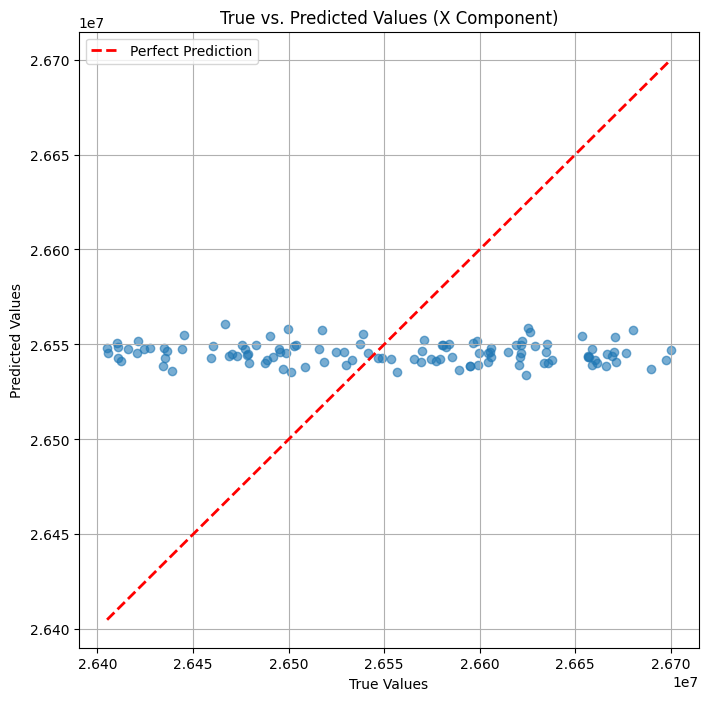

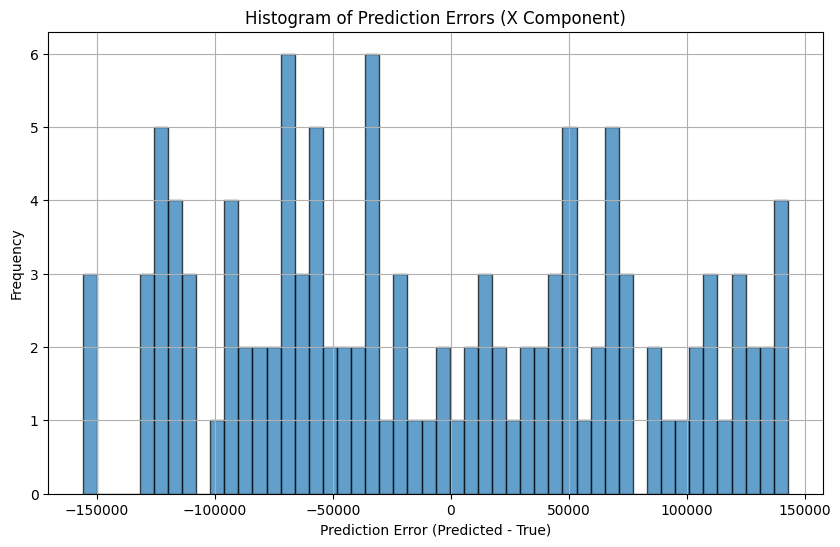

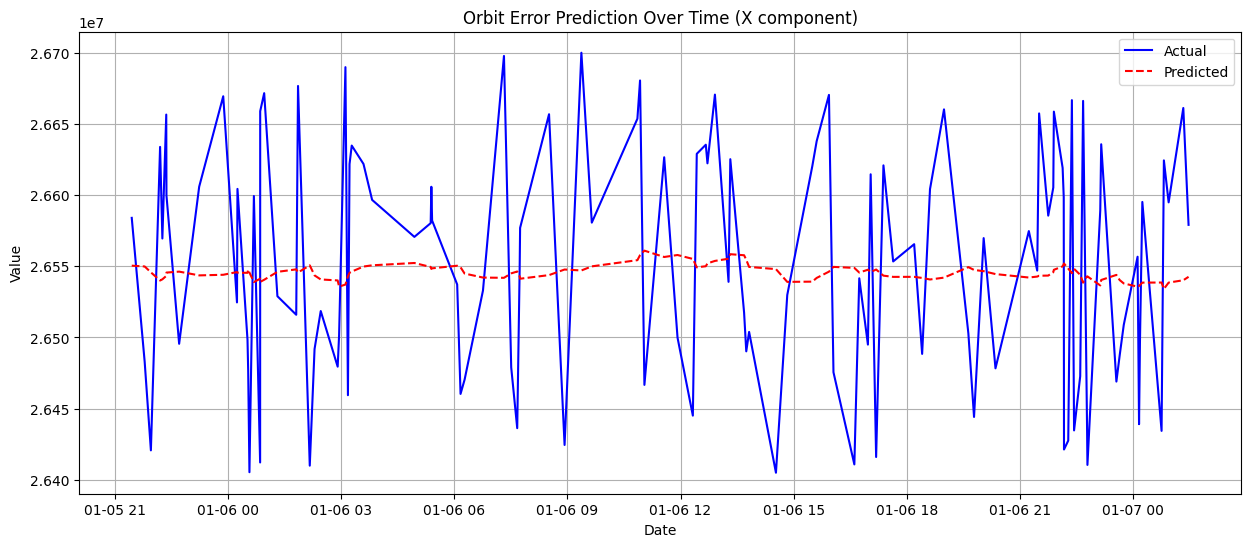

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Setup and Data Loading
try:
    df = pd.read_csv('generated_data.csv')
    df['epoch'] = pd.to_datetime(df['epoch'])
    df.set_index('epoch', inplace=True)
    df.sort_index(inplace=True)
    print("Data loaded successfully.")
    print("Preview of the data:")
    print(df.head())
except FileNotFoundError:
    print("Please upload 'generated_data.csv' first.")
    exit()

# 2. Preprocess Data and Create Time Sequences
n_timesteps = 96
features = ['x', 'y', 'z', 'clockBias_x']
data = df[features].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, n_timesteps):
    X, y = [], []
    if len(data) <= n_timesteps:
        return np.array(X), np.array(y)
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i + n_timesteps, :])
        y.append(data[i + n_timesteps, :])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data, n_timesteps)

if X_seq.size > 0:
    X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], len(features)))
else:
    print("\n⚠ Warning: Not enough data to create sequences for the model. Please provide more data.")
    exit()

# --- REVISED: Split the data based on a percentage instead of a fixed date ---
split_ratio = 0.8
split_index = int(X_seq.shape[0] * split_ratio)

X_train = X_seq[:split_index]
y_train = y_seq[:split_index]
X_test = X_seq[split_index:]
y_test = y_seq[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 3. Build and Train the LSTM Model
n_features = len(features)
n_hidden_units = 50

model = Sequential()
model.add(LSTM(n_hidden_units, activation='relu', input_shape=(X_train.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# 4. Evaluate and Visualize Predictions
if X_test.size == 0:
    print("\n⚠ No test data available for evaluation. Please provide more data.")
else:
    predicted_scaled = model.predict(X_test)

    dummy_actual = np.zeros(shape=(len(y_test), len(features)))
    dummy_actual[:, :] = y_test
    dummy_predicted = np.zeros(shape=(len(predicted_scaled), len(features)))
    dummy_predicted[:, :] = predicted_scaled

    y_test_original = scaler.inverse_transform(dummy_actual)
    y_predicted_original = scaler.inverse_transform(dummy_predicted)

    print("\n--- Evaluation Metrics on 8th Day ---")
    rmse_scores = {}
    mae_scores = {}
    for i, feature in enumerate(features):
        rmse = np.sqrt(mean_squared_error(y_test_original[:, i], y_predicted_original[:, i]))
        mae = mean_absolute_error(y_test_original[:, i], y_predicted_original[:, i])
        rmse_scores[feature] = rmse
        mae_scores[feature] = mae
        print(f"Feature: {feature}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")

    # --- Visualizations ---
    test_timestamps = df.index[df.shape[0] - X_test.shape[0] - n_timesteps:]

    if len(test_timestamps) > len(y_predicted_original):
        test_timestamps = test_timestamps[:len(y_predicted_original)]
    elif len(test_timestamps) < len(y_predicted_original):
        y_test_original = y_test_original[:len(test_timestamps)]
        y_predicted_original = y_predicted_original[:len(test_timestamps)]

    # 1. Scatter Plot of True vs. Predicted Values (for X component)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_original[:, 0], y_predicted_original[:, 0], alpha=0.6)
    plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()],
             [y_test_original[:, 0].min(), y_test_original[:, 0].max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.title('True vs. Predicted Values (X Component)')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Histogram of Prediction Errors (for X component)
    errors = y_predicted_original[:, 0] - y_test_original[:, 0]
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.title('Histogram of Prediction Errors (X Component)')
    plt.xlabel('Prediction Error (Predicted - True)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # 3. Line Plot of Predictions over Time (for X component)
    plt.figure(figsize=(15, 6))
    plt.plot(test_timestamps, y_test_original[:, 0], label='Actual', color='blue')
    plt.plot(test_timestamps, y_predicted_original[:, 0], label='Predicted', color='red', linestyle='--')
    plt.title('Orbit Error Prediction Over Time (X component)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()